## 1. Import needed packages

At first, we need to import all the needed packages

In [17]:
# Disable warnings
import warnings
warnings.filterwarnings("ignore")

# Import pyplot from matplotlib
import matplotlib.pyplot as plt

# Import TensorFlow & Keras 
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as tf_backend 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, ModelCheckpoint
from sklearn.decomposition import PCA

# Import all other needed packages
import scipy.stats as stats
import numpy as np
import math
import csv
from PIL import Image
import random
import os
import json
import pandas as pd

%matplotlib inline

## 2. Load all vectors

CSV file is formatted in the following way:

| entry_id | path_to_image    | person_id | $x_1$    | $x_2$    | $\dots$  | $x_N$    | 
| ---      |  ---             | ---       | ----     | ----     | ----     | -----    |
| 1        | ./images/001.png | 1         | $-0.5$   | $0.4$    | $\dots$  | $-0.25$  |
| 2        | ./images/028.png | 312       | $-0.67$  | $0.23$   | $\dots$  | $0.81$   |
| $\vdots$ | $\vdots$         | $\vdots$  | $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ |

Where $x_i$ denotes a column of $i$th component of an input vector $\mathbf{x}$

In [2]:
# Initializing a set of vectors and corresponding labels
X, Y = [], []

with open('./csv_datasets/face_recognition_celeba.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for i, row in enumerate(reader):
        # Omitting the table header
        if i == 0:
            continue
        
        # Third column is a column with person id
        label = int(float(row[2]))
        vector = np.array(row[3:]).astype(np.float)
        
        X.append(vector)
        Y.append(label)

In [23]:
print('Number of vectors (and labels, respectively) is', len(X))

Number of vectors (and labels, respectively) is 196855


## Binary distance and converting rule

Binary distance is defined as follows:

$$
\delta(\mathbf{x}, \mathbf{y}) = \frac{1}{N}\sum_{k=1}^N |x_j-y_j|
$$

Converting rule is defined as:
$$
\psi(\mathbf{x} \mid \mathbf{t}) := \mathring{\mathbb{I}}(\mathbf{x} > \mathbf{t})
$$

In [16]:
def binary_distance(x, y):
    return tf.reduce_mean(tf.abs(x-y),axis=0)

# Check binary distance formula
x = tf.constant([0.0, 0.0, 1.0, 1.0])
print('Vector x is', x)
y = tf.constant([0.0, 0.0, 1.0, 0.0])
print('Vector y is', y)
print('Distance between them is', binary_distance(x, y))
print('-'*30)

def convert_to_binary_string(f, t):
    return tf.where(tf.less(f, t), 0.0, 1.0)

f = tf.constant([1.3, 2.5, -2.3, 0.2, -0.3])
print('Vector f is', f)
print('Converted f given zero vector is', convert_to_binary_string(f, tf.zeros(shape=(5,))))
print('-'*30)

def binary_distance_vectors(f1, f2, t):
    return binary_distance(convert_to_binary_string(f1, t), convert_to_binary_string(f2, t))

f1 = tf.constant([-0.2, -0.3, 0.4, 0.5])
f2 = tf.constant([-0.6, -0.7, 0.8, -0.9])
print('Vector f1 is', f1)
print('Vector f2 is', f2)
print('Binary distance between these two vectors is', binary_distance_vectors(f1, f2, tf.zeros(shape=(4,))))
print('-'*30)

test_vector = X[100]
print('Now just to test our loaded vectors, let us load some vector from our dataset:', X[100])
print('Converted is', convert_to_binary_string(test_vector, np.zeros(shape=(128,))))

Vector x is tf.Tensor([0. 0. 1. 1.], shape=(4,), dtype=float32)
Vector y is tf.Tensor([0. 0. 1. 0.], shape=(4,), dtype=float32)
Distance between them is tf.Tensor(0.25, shape=(), dtype=float32)
------------------------------
Vector f is tf.Tensor([ 1.3  2.5 -2.3  0.2 -0.3], shape=(5,), dtype=float32)
Converted f given zero vector is tf.Tensor([1. 1. 0. 1. 0.], shape=(5,), dtype=float32)
------------------------------
Vector f1 is tf.Tensor([-0.2 -0.3  0.4  0.5], shape=(4,), dtype=float32)
Vector f2 is tf.Tensor([-0.6 -0.7  0.8 -0.9], shape=(4,), dtype=float32)
Binary distance between these two vectors is tf.Tensor(0.25, shape=(), dtype=float32)
------------------------------
Now just to test our loaded vectors, let us load some vector from our dataset: [-0.10663576  0.10767722 -0.00263303 -0.05884297 -0.18547623  0.11882087
 -0.06442317 -0.12119251  0.10216916 -0.05668224  0.18726218 -0.03251313
 -0.27963877 -0.1144882   0.09311682  0.13558465 -0.07973736 -0.15667976
 -0.16170803 -0.04

## Sigma score

Our goal is to maximize $\hat{\sigma}_{\text{same}}$ while also maximizing the difference $\hat{\sigma}_{\text{same}}-\hat{\sigma}_{\text{diff}}$ To encapsulate these rules into a single measure, we define the $\Sigma$-score and define it as:
$$
\overline{\Sigma}(\hat{\sigma}_{\text{same}},\hat{\sigma}_{\text{diff}} \mid \epsilon) = \left[\log \frac{\hat{\sigma}_{\text{same}}}{\hat{\sigma}_{\text{diff}}+\epsilon}\right]_+
$$

Text(0.5, 0, 'Sigma score')

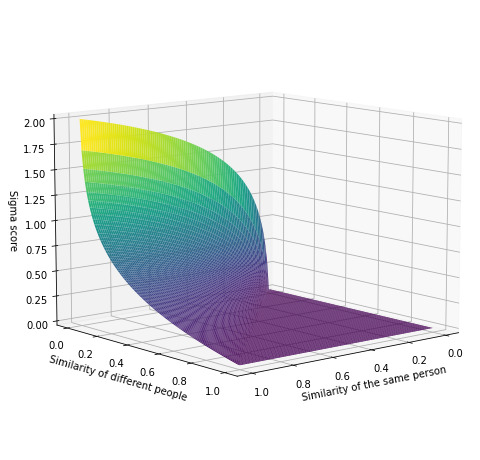

In [4]:
def sigma_score(x,y):
    return np.maximum(np.log10(x/(y+0.01)), 0)

x_values = np.linspace(0, 1, 100)
y_values = np.linspace(0, 1, 100)

X_mesh, Y_mesh = np.meshgrid(x_values, y_values)
Z_mesh = sigma_score(X_mesh, Y_mesh)

plt.figure(figsize=(8,10))
ax = plt.axes(projection='3d')
ax.view_init(10, 50)
ax.plot_surface(X_mesh, Y_mesh, Z_mesh, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('Similarity of the same person')
ax.set_ylabel('Similarity of different people')
ax.set_zlabel('Sigma score')

### Expected value $\mathbb{E}[X]$
Suppose we have $\{\mathbf{x}_k\}_{k=1}^N$. Then the expected value:
$$
\mathbb{E}(X) \equiv \mu = \frac{1}{N} \sum_{k=1}^N \mathbf{x}_k
$$

In [20]:
expected_value = np.mean(X, axis=0)
print('Expected value is', expected_value)

Expected value is [-0.10458748  0.08706951  0.06313406 -0.06834802 -0.11555941 -0.00979868
 -0.02654224 -0.09836311  0.17026608 -0.08008751  0.18170208 -0.03859668
 -0.24979736 -0.01368936 -0.04673888  0.14272029 -0.15934551 -0.14908355
 -0.08464895 -0.06524961  0.03316814  0.03510629  0.01980594  0.0727367
 -0.1413669  -0.31101325 -0.06332893 -0.08184028  0.01281158 -0.10200401
  0.01932193  0.07472957 -0.18369906 -0.02141437  0.02411318  0.09859298
 -0.04340459 -0.09916782  0.18464858  0.00860688 -0.20341156 -0.0178978
  0.06312869  0.25923566  0.20323607 -0.0043442   0.02068386 -0.07309168
  0.12926551 -0.28091628  0.04385916  0.15405813  0.08311727  0.07087128
  0.07878043 -0.17088928  0.02651652  0.13531725 -0.18804385  0.06249529
  0.06163731 -0.0891576  -0.01549824 -0.07037112  0.1961034   0.10033608
 -0.12160869 -0.14259897  0.1670615  -0.15974705 -0.04638151  0.09949948
 -0.11331245 -0.18660063 -0.26002088  0.02392384  0.38388648  0.14962179
 -0.15760351  0.03222013 -0.0746737

## Applying PCA to our dataset

Just a beautiful picture :0

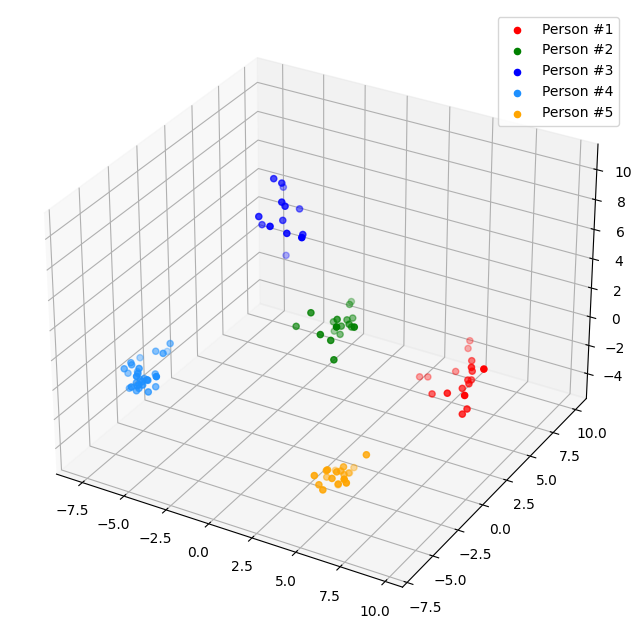

In [22]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

pca = PCA(n_components=3)

batch_1 = [vector for k, vector in enumerate(X) if Y[k] == 10]
color_1 = [1] * len(batch_1)
batch_2 = [vector for k, vector in enumerate(X) if Y[k] == 20]
color_2 = [2] * len(batch_2)
batch_3 = [vector for k, vector in enumerate(X) if Y[k] == 50]
color_3 = [3] * len(batch_3)
batch_4 = [vector for k, vector in enumerate(X) if Y[k] == 21]
color_4 = [4] * len(batch_4)
batch_5 = [vector for k, vector in enumerate(X) if Y[k] == 90]
color_5 = [5] * len(batch_5)

batches = [*batch_1, *batch_2, *batch_3, *batch_4, *batch_5]
colors = [*color_1, *color_2, *color_3, *color_4, *color_5]

batch_scaled = preprocessing.StandardScaler().fit_transform(batches)
pca_features = pca.fit_transform(batch_scaled)

plt.style.use('default')

# Plot scaled features
xdata = pca_features[:,0]
ydata = pca_features[:,1]
zdata = pca_features[:,2]
 
# Plot 3D plot
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')

n1 = len(batch_1)
n2 = len(batch_1) + len(batch_2)
n3 = len(batch_1) + len(batch_2) + len(batch_3)
n4 = len(batch_1) + len(batch_2) + len(batch_3) + len(batch_4)
n5 = len(batch_1) + len(batch_2) + len(batch_3) + len(batch_4) + len(batch_5)

ax.scatter3D(xdata[:n1], ydata[:n1], zdata[:n1], c='r', label='Person #1', cmap='jet')
ax.scatter3D(xdata[n1:n2], ydata[n1:n2], zdata[n1:n2], c='g', label='Person #2', cmap='jet')
ax.scatter3D(xdata[n2:n3], ydata[n2:n3], zdata[n2:n3], c='b', label='Person #3', cmap='jet')
ax.scatter3D(xdata[n3:n4], ydata[n3:n4], zdata[n3:n4], c='dodgerblue', label='Person #4', cmap='jet')
ax.scatter3D(xdata[n4:n5], ydata[n4:n5], zdata[n4:n5], c='orange', label='Person #5', cmap='jet')

ax.legend()
#ax.scatter3D(xdata, ydata, zdata, c=colors, cmap='jet')
 
# Plot title of graph

plt.show()

## Forming set of pairs

Set of similar pairs $\mathcal{P}_{\text{same}}$ would be formed by simply taking adjacent pairs in a batch of images in the same class $\mathbf{}$

Set of different pairs $\mathcal{P}_{\text{diff}}$ would be formed by taking $i$th element from batches $j$ and $j+1$

At first, let us form set of batches

In [24]:
# Initialize a list of unique classes
Y_unique = np.unique(Y)
# Initialize a list of images (image from the same batch correspond to the same class)
X_batches = []

for c in Y_unique:
    X_batches.append([x for i,x in enumerate(X) if Y[i] == c])

print('Number of batches is', len(X_batches))
print('Number of unique labels', len(Y_unique))
print('These two numbers must coincide!')

Number of batches is 10173
Number of unique labels 10173
These two numbers must coincide!


## Calculating same similarity
Suppose we have $\mathcal{B} = \{B_1, B_2, \dots, B_M\}$ a set of batches with the same classes

Then, we evaluate same similarity as:
$$
\hat{\sigma}_{\text{same}} = \frac{\sum_{B \in \mathcal{B}} \sum_{j=1}^{|B|-1}\delta(\psi(B_j\mid \mu),\psi(B_{j+1}\mid\mu))}{\sum_{B \in \mathcal{B}} (|B|-1)}
$$

And different similarity as:
$$
\hat{\sigma}_{\text{diff}} = \frac{\sum_{i=1}^{|\mathcal{B}|-1}\sum_{j=1}^{\min\{|B_j|,|B_{j+1}|\}} \delta(\psi(B_{i,j}\mid\mu),\psi(B_{i+1,j}\mid\mu))}{\sum_{j=1}^{|\mathcal{B}|-1}\min\{|B_j|,|B_{j+1}|\}}
$$

In [25]:
# Sum of all sigmas when threshold = expected value and 0, respectively
total_sigma_same_E = 0.0
total_sigma_same_0 = 0.0
# Number of entries in the sum (as we would need further calculate average value)
sigma_same_entries = 0

for batch in X_batches:
    for j in range(0, len(batch)-1):
        total_sigma_same_E += (1.0 - binary_distance_vectors(batch[j], batch[j+1], expected_value))
        total_sigma_same_0 += (1.0 - binary_distance_vectors(batch[j], batch[j+1], np.zeros(shape=(128,))))
        sigma_same_entries += 1

In [50]:
print('Same similarity using threshold = 0:', float(average_sigma_same_0))
print('Same similarity using expectation value as a threshold:', float(average_sigma_same_E))

Same similarity using threshold = 0: 0.8899619579315186
Same similarity using expectation value as a threshold: 0.7448511123657227


In [33]:
# Sum of all sigmas when threshold = expected value and 0, respectively
total_sigma_diff_E = 0.0
total_sigma_diff_0 = 0.0
# Number of entries in the sum (as we would need further calculate average value)
sigma_diff_entries = 0

for i in range(len(X_batches)-1):
    current_number_of_pairs = min(len(X_batches[i]), len(X_batches[i+1]))
    for j in range(current_number_of_pairs-1):
        total_sigma_diff_E += 1 - binary_distance_vectors(X_batches[i][j], X_batches[i+1][j], expected_value)
        total_sigma_diff_0 += 1 - binary_distance_vectors(X_batches[i][j], X_batches[i+1][j], np.zeros(shape=(128,)))
        sigma_diff_entries += 1
        
average_sigma_diff_E = total_sigma_diff_E / sigma_diff_entries
average_sigma_diff_0 = total_sigma_diff_0 / sigma_diff_entries

In [51]:
print('Different similarity using threshold = 0:', float(average_sigma_diff_0))
print('Different similarity using expectation value as a threshold:', float(average_sigma_diff_E))

Different similarity using threshold = 0: 0.8024696707725525
Different similarity using expectation value as a threshold: 0.5286825895309448


## Calculate Sigma score and draw everything beautifully :)

In [47]:
sigma_score_0 = sigma_score(float(average_sigma_same_0), float(average_sigma_diff_0))
sigma_score_E = sigma_score(float(average_sigma_same_E), float(average_sigma_diff_E))

data = [['Zero vector', float(average_sigma_same_0), float(average_sigma_same_E), sigma_same_entries, sigma_score_0],
        ['Expected value', float(average_sigma_diff_0), float(average_sigma_diff_E), sigma_diff_entries, sigma_score_E]]
pd.DataFrame(data, columns=["Threshold type", "Sigma same", "Sigma diff", "# of pairs", "Sigma score"])

,Threshold type,Sigma same,Sigma diff,# of pairs,Sigma score
0,Zero vector,0.889962,0.744851,186682,0.039564
1,Expected value,0.802470,0.528683,139481,0.140737
